In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [25]:
#任意计算两点之间距离
def cal_pairwise_dist(data):
	expand_ = data[:, np.newaxis, :]
	repeat1 = np.repeat(expand_, data.shape[0], axis=1)
	repeat2 = np.swapaxes(repeat1, 0, 1)
	D = np.linalg.norm(repeat1 - repeat2, ord=2, axis=-1, keepdims=True).squeeze(-1)
	return D

In [26]:
#计算近邻        
def get_n_neighbors(data, n_neighbors):
	dist = cal_pairwise_dist(data)
	dist[dist < 0] = 0
	n = dist.shape[0]
	N = np.zeros((n, n_neighbors))
	for i in range(n):
		# np.argsort 列表从小到大的索引
		index_ = np.argsort(dist[i])[1:n_neighbors+1]
		N[i] = N[i] + index_
	return N.astype(np.int32) 

In [46]:
#LLE过程
def LLE(data, n_dims, n_neighbors,jump=True):
	N = get_n_neighbors(data, n_neighbors)            # k近邻索引
	n, D = data.shape                                 # n_samples, n_features
	# prevent Si to small
	if n_neighbors > D:
		tol = 1e-3
	else:
		tol = 0
	# calculate W
	W = np.zeros((n_neighbors, n))
	I = np.ones((n_neighbors, 1))
	for i in range(n):                                # data[i] => [1, n_features]
		Xi = np.tile(data[i], (n_neighbors, 1)).T     # [n_features, n_neighbors]
		                                              # N[i] => [1, n_neighbors]
		Ni = data[N[i]].T                             # [n_features, n_neighbors]
		Si = np.dot((Xi-Ni).T, (Xi-Ni))               # [n_neighbors, n_neighbors]
		Si = Si + np.eye(n_neighbors)*tol*np.trace(Si)
		Si_inv = np.linalg.pinv(Si)
		wi = (np.dot(Si_inv, I)) / (np.dot(np.dot(I.T, Si_inv), I)[0,0])
		W[:, i] = wi[:,0]
	W_y = np.zeros((n, n))
	for i in range(n):
		index = N[i]
		for j in range(n_neighbors):
			W_y[index[j],i] = W[j,i]
	I_y = np.eye(n)
	M = np.dot((I_y - W_y), (I_y - W_y).T)
	eig_val, eig_vector = np.linalg.eig(M)

	
	if jump==True:
		index_=np.argsort(eig_val)
		eig_val=eig_val[index_]
		j=0
		while eig_val[j]<1e-6:
			j+=1
		index_=index_[j:j+n_dims]
		eig_vec_picked=eig_vector[:,index_]
		Y=eig_vec_picked

	if jump==False:
		index_ = np.argsort(np.abs(eig_val))[1:n_dims+1]
		Y = eig_vector[:, index_]
	return Y

## 拟合数据

y= [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


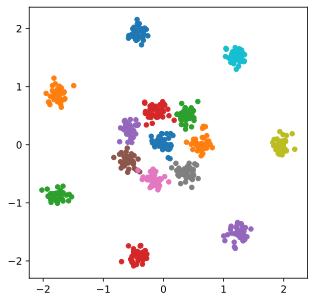

In [63]:
data=np.loadtxt('../data/data/synthetic/R15.txt')
x=data[:,1:]
y=data[:,0]
print("y=",np.unique(y))
ss_x=StandardScaler()
x=ss_x.fit_transform(x)

plt.figure(figsize=(5,5))
for i in np.unique(y):
    plt.scatter(x[y==i,0],x[y==i,1],s=20)

Text(0.5, 1.0, 'LLE')

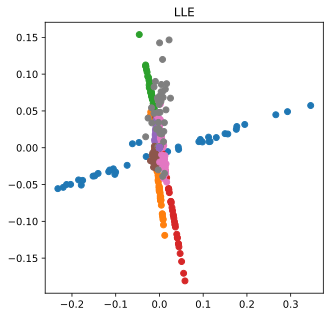

In [65]:
x_DR=LLE(x,2,10,jump=True)
plt.figure(figsize=(5,5))
for i in np.unique(y):
    plt.scatter(x_DR[y==i,0],x_DR[y==i,1])
plt.title("LLE")

## 瑞士卷

In [51]:
def load_data():
    swiss_roll =datasets.make_swiss_roll(n_samples=1000)
    return swiss_roll[0],np.floor(swiss_roll[1])

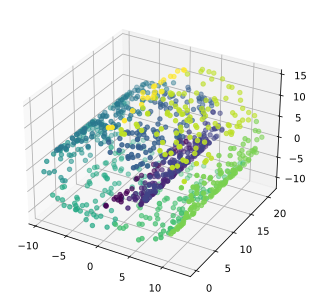

In [52]:
X,Y=load_data()
fig = plt.figure('data')
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2],marker='o',c=Y)

D:\app\Anaconda3\lib\site-packages\matplotlib\collections.py:202: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


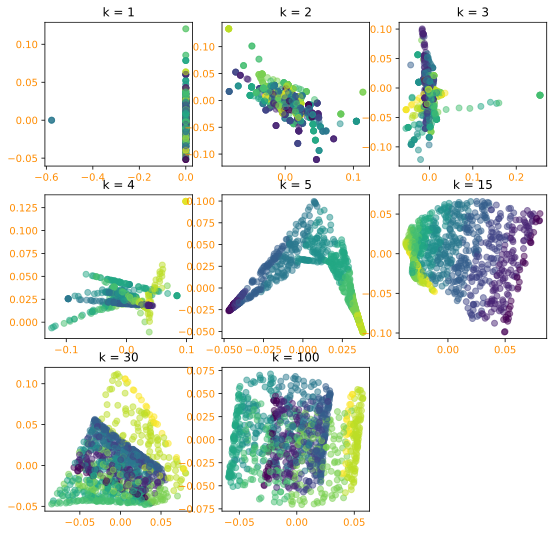

In [53]:
fig=plt.figure("LLE",figsize=(9, 9))
Neighbors=[1,2,3,4,5,15,30,100]
for i,k in enumerate(Neighbors): #i位置，k代表的值
        lle=LLE(X,2,k,jump=False)
        ax=fig.add_subplot(3,3,i+1)
        ax.scatter(lle[:,0],lle[:,1],marker='o',c=Y,alpha=0.5) #c代表颜色
        ax.set_title("k = %d"%k)   
        plt.xticks(fontsize=10, color="darkorange")  
        plt.yticks(fontsize=10, color="darkorange") 
#plt.suptitle("LLE")   #总图标题
plt.show()
    


## 调包LLE

In [54]:
from sklearn.manifold import LocallyLinearEmbedding

Text(0.5, 1.0, 'LLE')

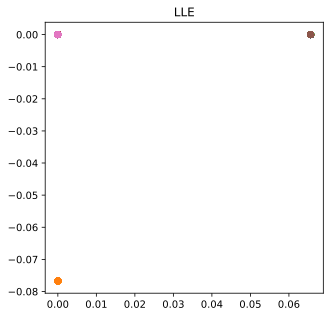

In [57]:
model_LLE=LocallyLinearEmbedding(n_neighbors=10,n_components=2).fit_transform(x)
plt.figure(figsize=(5,5))
for i in np.unique(y):
    plt.scatter(model_LLE[y==i,0],model_LLE[y==i,1])
plt.title("LLE")

n = 3 重建误差： 1.1504520600227164e-09
n = 2 重建误差： 2.4810780031874227e-10
n = 1 重建误差： 2.8626374661452598e-11


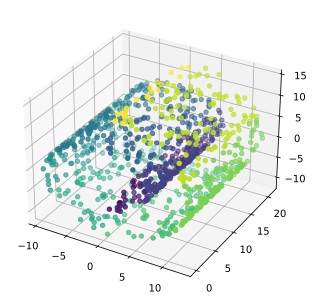

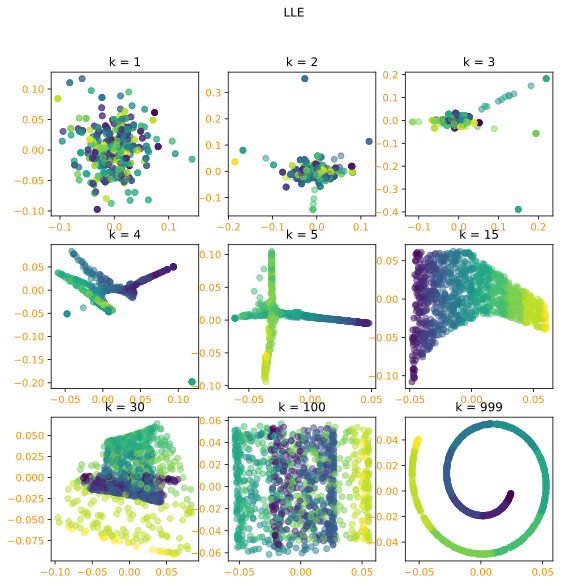

In [58]:
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn import datasets,decomposition,manifold
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
def load_data():
    swiss_roll =datasets.make_swiss_roll(n_samples=1000)
    return swiss_roll[0],np.floor(swiss_roll[1])
 
def LLE_components(*data):
    X,Y=data
    for n in [3,2,1]:
        lle=manifold.LocallyLinearEmbedding(n_components=n)  #LLE降维，n_components降的维数 #n_neighbors近邻数
        lle.fit(X)
        print("n = %d 重建误差："%n,lle.reconstruction_error_)
 
def LLE_neighbors(*data):
    X,Y=data
    Neighbors=[1,2,3,4,5,15,30,100,Y.size-1]
 
    fig=plt.figure("LLE",figsize=(9, 9))
  
    for i,k in enumerate(Neighbors): #i位置，k代表的值
        lle=manifold.LocallyLinearEmbedding(n_components=2,n_neighbors=k,eigen_solver='dense')
        X_r=lle.fit_transform(X)
        ax=fig.add_subplot(3,3,i+1)
        ax.scatter(X_r[:,0],X_r[:,1],marker='o',c=Y,alpha=0.5) #c代表颜色
        ax.set_title("k = %d"%k)   
        plt.xticks(fontsize=10, color="darkorange")  
        plt.yticks(fontsize=10, color="darkorange") 
    plt.suptitle("LLE")
    plt.show()
 
X,Y=load_data()
fig = plt.figure('data')
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2],marker='o',c=Y)
LLE_components(X,Y)
LLE_neighbors(X,Y)
